In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [1]:
import tensorflow

tensorflow.__version__

'2.3.0'

In [2]:
import pandas as pd
import sys
import os

import pandas as pd
import numpy as np
np.random.seed(1)

import cv2
import PIL
from IPython.display import Image, display # To show images

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator,DirectoryIterator

from keras import backend as K
from sklearn.utils import shuffle 
from sklearn.metrics import precision_score, recall_score # For performance metrics

import glob
import plotly.express as px # For histograms
import plotly.graph_objects as go # For pie charts

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
CONDITION_LABELS = {
    0 : "NORMAL",
    1 : "PNEUMONIA"
}

num_classes = 2
input_shape = (100, 100, 3)

IMAGE_SIZE = (300,300)

TRAIN_PATH = ['train/NORMAL','train/PNEUMONIA']
VAL_PATH = ['val/NORMAL','val/PNEUMONIA']
TEST_PATH = ['test/NORMAL','test/PNEUMONIA']

In [4]:
def create_dataset(dataset_path):    
    def parse_dataset(dataset_path,ext='jpeg'):
        """
        Used to extract information about our dataset. 
        It does iterate over all images and return a DataFrame with
        the data of all files.
        """      
        files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))

        records = []
        for file in files:
            if "NORMAL" in file:
                records.append(0)
            else:
                records.append(1)

        df = pd.DataFrame()
        df['file'] = files
        df['label'] = records

        return df
    
    #concatinate the normal and pneumonia images.
    result_ds = pd.DataFrame()
    for path in dataset_path:
        temp_ds = parse_dataset(path)
        result_ds = pd.concat([result_ds,temp_ds])
            
    result_ds = result_ds.sample(frac=1)      #shuffle the result_ds 
    return result_ds

In [5]:
train_ds = create_dataset(TRAIN_PATH)
val_ds = create_dataset(VAL_PATH)
test_ds = create_dataset(TEST_PATH)

print("Train dataset, size: {}".format(train_ds.shape[0] ))
display(train_ds.head())

print("Valid dataset, size: {}".format(val_ds.shape[0] ))
display(val_ds.head())

print("Test dataset, size: {}".format(test_ds.shape[0] ))
display(test_ds.head())

Train dataset, size: 5216


,file,label
28,train/NORMAL\IM-0170-0001.jpeg,0
393,train/PNEUMONIA\person1206_bacteria_3158.jpeg,1
2094,train/PNEUMONIA\person341_bacteria_1577.jpeg,1
1162,train/NORMAL\NORMAL2-IM-1157-0001.jpeg,0
2478,train/PNEUMONIA\person442_virus_898.jpeg,1


Valid dataset, size: 16


,file,label
0,val/NORMAL\NORMAL2-IM-1427-0001.jpeg,0
7,val/NORMAL\NORMAL2-IM-1442-0001.jpeg,0
2,val/NORMAL\NORMAL2-IM-1431-0001.jpeg,0
4,val/PNEUMONIA\person1950_bacteria_4881.jpeg,1
0,val/PNEUMONIA\person1946_bacteria_4874.jpeg,1


Test dataset, size: 624


,file,label
348,test/PNEUMONIA\person83_bacteria_409.jpeg,1
154,test/PNEUMONIA\person152_bacteria_724.jpeg,1
302,test/PNEUMONIA\person54_virus_109.jpeg,1
291,test/PNEUMONIA\person44_virus_94.jpeg,1
315,test/PNEUMONIA\person69_virus_129.jpeg,1


In [6]:
def show_images(ds, n):
    '''
        This function shows n number of images of a given dataset.
        
        inputs: DataFrame ds, Int n
    '''
    for i in range(n):
        file_name = ds.iloc[i,0]
        img = cv2.imread(file_name)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img,IMAGE_SIZE)
        img = np.array(img)
        display(PIL.Image.fromarray(img))
        print("Condition type: {}".format(CONDITION_LABELS[ds.iloc[i,1]]))

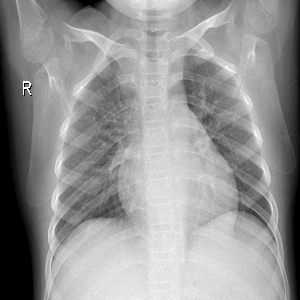

Condition type: NORMAL


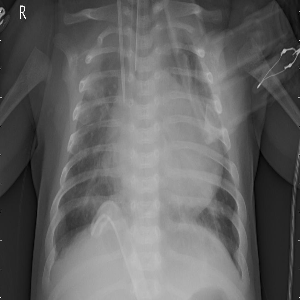

Condition type: PNEUMONIA


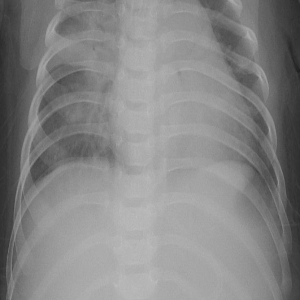

Condition type: PNEUMONIA


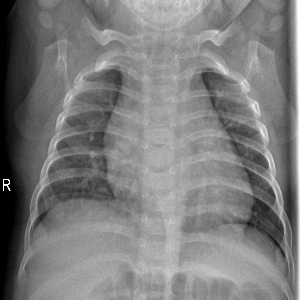

Condition type: NORMAL


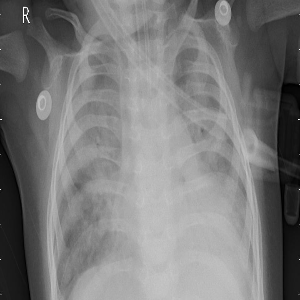

Condition type: PNEUMONIA


In [7]:
show_images(train_ds, 5)

In [8]:
images = []
labels = []

train_images = []

for i in range(train_ds.shape[0]):
    file_name = train_ds.iloc[i,0]
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(100,100))
    images.append(img)
    labels.append(train_ds.iloc[i,1])

images = np.array(images, dtype = 'float32')
labels = np.array(labels, dtype = 'int32')

train_images.append((images, labels))

In [9]:
images1 = []
labels1 = []

test_images = []

for i in range(test_ds.shape[0]):
    file_name = test_ds.iloc[i,0]
    img = cv2.imread(file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(100,100))
    images1.append(img)
    labels1.append(test_ds.iloc[i,1])
    
images1 = np.array(images1, dtype = 'float32')
labels1 = np.array(labels1, dtype = 'int32')
    
test_images.append((images1, labels1))

In [10]:
# NORMALIZE_VAL = 255.0
# images = images/NORMALIZE_VAL
# images1 =  images1/NORMALIZE_VAL

In [11]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 5
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [12]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(images)

In [13]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [14]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


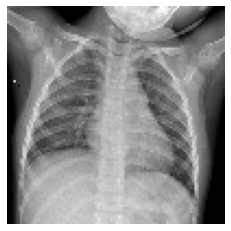

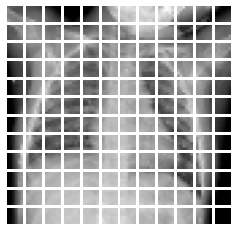

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
img = images[np.random.choice(range(images.shape[0]))]
plt.imshow(img.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([img]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [16]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [17]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [18]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "C:/Users/hongt/Documents/Thinh/full_pneumonia/chest_xray"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=images,
        y=labels,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(images1, labels1)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
#history = run_experiment(vit_classifier)


Epoch 1/5
19/19 [==============================] - 196s 10s/step - loss: 2.7628 - accuracy: 0.7177 - top-5-accuracy: 1.0000 - val_loss: 0.2266 - val_accuracy: 0.9023 - val_top-5-accuracy: 1.0000
Epoch 2/5
19/19 [==============================] - 183s 10s/step - loss: 0.3698 - accuracy: 0.8596 - top-5-accuracy: 1.0000 - val_loss: 0.2197 - val_accuracy: 0.9310 - val_top-5-accuracy: 1.0000
Epoch 3/5
19/19 [==============================] - 183s 10s/step - loss: 0.3103 - accuracy: 0.8738 - top-5-accuracy: 1.0000 - val_loss: 0.2192 - val_accuracy: 0.9157 - val_top-5-accuracy: 1.0000
Epoch 4/5
19/19 [==============================] - 184s 10s/step - loss: 0.2883 - accuracy: 0.8746 - top-5-accuracy: 1.0000 - val_loss: 0.1838 - val_accuracy: 0.9425 - val_top-5-accuracy: 1.0000
Epoch 5/5
20/20 [==============================] - 7s 343ms/step - loss: 0.3729 - accuracy: 0.8494 - top-5-accuracy: 1.0000
Test accuracy: 84.94%
Test top 5 accuracy: 100.0%
